In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv("Housing.csv")
df.sample(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
20,8750000,4320,3,1,2,yes,no,yes,yes,no,2,no,semi-furnished
152,5565000,5400,5,1,2,yes,yes,yes,no,yes,0,yes,furnished
373,3640000,3000,2,1,2,yes,no,no,no,yes,0,no,furnished
74,6650000,4040,3,1,2,yes,no,yes,yes,no,1,no,furnished
464,3080000,4500,2,1,2,yes,no,no,yes,no,1,no,semi-furnished


# Data Cleaning and Pre- Processing

In order to conduct a better data analysis on this dataset, I must first describe and check to see if there are any null values

In [4]:
# get some information from the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


The dataset seems to be kept very clean. Out of the 545 entries, there are no null values throughout the entire dataframe. The only thing that I have to keep in mind is that there seems to be a small sample of data. This might pose a problem for splitting the data during the testing phase. I will have to see what other data manipulation techniques that I can apply in order to make an adequate model.

In [5]:
# Look at a variety of summary statistics from the dataset

df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


From the desribe feature we can get a little deeper understanding of the dataset. (The numerical portions of the dataset)

75% of the Housing Prices fall within the range of 3.430000e+0.6 - 7.740000e+0.6.

In [6]:
df.corr()

,price,area,bedrooms,bathrooms,stories,parking
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.384394
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.352980
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,0.139270
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.177496
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.045547
parking,0.384394,0.352980,0.139270,0.177496,0.045547,1.000000


Luckily for us, it seems that the numerical values are not too highly correlated with each other. So for the first pass, I wont remove any of the numerical columns.

## Data Visualization

This portion is me creating a variety of visualizations such as feature correlations and plotting the actual data itself to determine what the best regression model is

<AxesSubplot:>

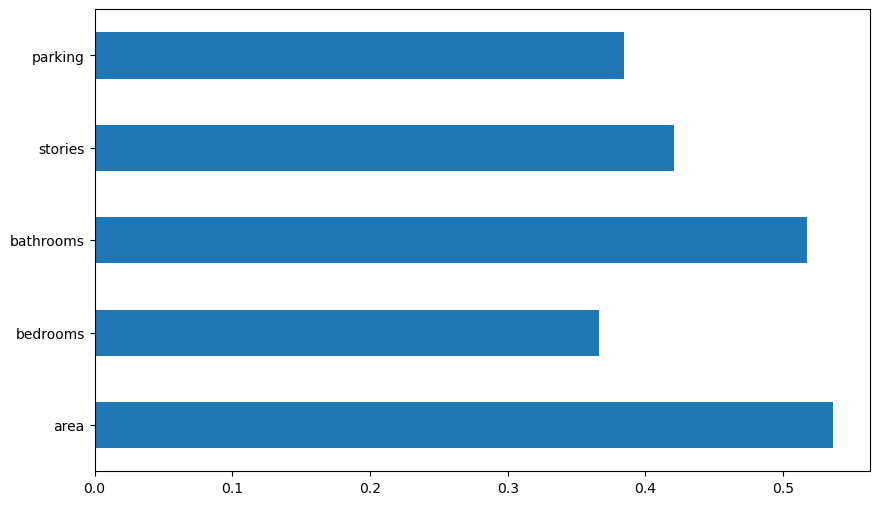

In [7]:
#let's create a correlation table to see which variables we might need to remove and which ones to keep

correlation_values = df.corr()["price"].drop("price")
correlation_values.plot(kind='barh', figsize=(10, 6))

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

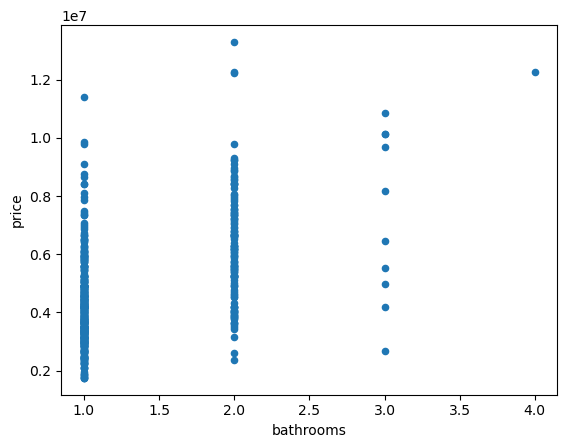

In [8]:
#look at the data itself and see if there is any discernable reltaionship between everything 

df.plot.scatter(x = "bathrooms", y = "price")

<AxesSubplot:xlabel='area', ylabel='price'>

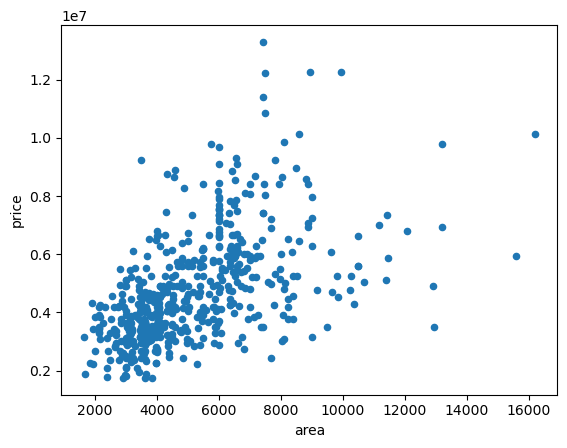

In [29]:
df.plot.scatter(x = "area", y = "price")

# Data Pre-Processing

This portion is me pre-processing the data and preparing the data to be fit into the pipeline.

The main models that I am going to test are DecisionTreeRegression, Linear Regression, and Logistic Regression

In [9]:
X = df.drop(columns = "price", axis = 1)
y = df["price"]

In [10]:
#split the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [11]:
#identify numeric and categorical features for transformations later on in the pipeline

numeric_features = X_train.select_dtypes(include = ["float64", "int64"]).columns.to_list()
categorical_features = X_train.select_dtypes(include = ["object","category"]).columns.to_list()

In [12]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

## Decision Tree Regressor 

In [32]:
#prepare the preprocessor for the pipelline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#create the pipeline with the DecisionTreeRegressor

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

#define paramter grid for cross validation

param_grid = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__splitter': ['best', 'random'],
    'regressor__criterion': ['mse', 'friedman_mse', 'mae']
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

In [33]:
#fit the grid search with the preprocessors, and pipelines, and cv 

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2', verbose=2)  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END regressor__criterion=mse, regressor__max_depth=None, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=None, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=None, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=None, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=None, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=None, regressor__min_samples_split=2, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=None, regressor__min_samples_split=2, regresso

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/daws

[CV] END regressor__criterion=mse, regressor__max_depth=5, regressor__min_samples_split=2, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=5, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=5, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=5, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=5, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=5, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=5, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mse, regressor

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is e

[CV] END regressor__criterion=mse, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is e

[CV] END regressor__criterion=mse, regressor__max_depth=20, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=20, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=20, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=20, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=20, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=20, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mse, regressor__max_depth=20, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterio

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is e

[CV] END regressor__criterion=friedman_mse, regressor__max_depth=None, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=friedman_mse, regressor__max_depth=None, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=friedman_mse, regressor__max_depth=None, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=friedman_mse, regressor__max_depth=None, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=friedman_mse, regressor__max_depth=None, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=friedman_mse, regressor__max_depth=None, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=friedman_mse, regressor__max_depth=None, regressor__min_samples_split=20

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which 

[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regres

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which 

[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=None, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=2, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, r

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which 

[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=10, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=5, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=m

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which 

[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=2, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=2, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=2, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, 

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which 

[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=10, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=20, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=10, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which 

[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=5, regressor__splitter=best; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=5, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which 

[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s
[CV] END regressor__criterion=mae, regressor__max_depth=20, regressor__min_samples_split=20, regressor__splitter=random; total time=   0.0s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['area',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'stories',
                                                                          'parking']),
                                                                        ('cat',
                                                                    

In [34]:
#Display the best hyperparamters

print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'regressor__criterion': 'mse', 'regressor__max_depth': None, 'regressor__min_samples_split': 10, 'regressor__splitter': 'best'}
Best cross-validation score: 0.56


In [35]:
test_score = grid_search.score(X_test, y_test)  
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.44


In [36]:
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean absolute error: " + str(mae)) 
print(f"Mean sqaured error: " + str(mse)) 
print(f"R2: " + str(r2)) 


Mean absolute error: 1256581.5443425078
Mean sqaured error: 2824045073513.9897
R2: 0.4412887870046227


## Linear Regression Model

In [37]:
#lets retry this with a multiple linear regression

from sklearn.linear_model import LinearRegression

In [38]:
pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

param_grid_1 = {
    'regressor__fit_intercept': [True, False],
    'regressor__copy_X': [True, False],
    'regressor__n_jobs': [-1, 1, 2, 4]
}

In [39]:
grid_search1 = GridSearchCV(pipeline1, param_grid_1, cv=cv, scoring='r2', verbose=2)  
grid_search1.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=1; total time=   0.0s
[CV] END regressor__copy_X=True, regressor__fit_intercept=True, regressor__n_jobs=1; total time=   0.0

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END regressor__copy_X=False, regressor__fit_intercept=True, regressor__n_jobs=2; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=True, regressor__n_jobs=4; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=True, regressor__n_jobs=4; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=True, regressor__n_jobs=4; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=True, regressor__n_jobs=4; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=True, regressor__n_jobs=4; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=False, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=False, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_intercept=False, regressor__n_jobs=-1; total time=   0.0s
[CV] END regressor__copy_X=False, regressor__fit_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['area',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'stories',
                                                                          'parking']),
                                                                        ('cat',
                                                                    

In [40]:
y_pred_1 = grid_search1.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_1)
mse = mean_squared_error(y_test, y_pred_1)
r2 = r2_score(y_test, y_pred_1)

print(f"Mean absolute error: " + str(mae)) 
print(f"Mean sqaured error: " + str(mse)) 
print(f"R2: " + str(r2)) 

Mean absolute error: 970043.4039201649
Mean sqaured error: 1754318687330.668
R2: 0.6529242642153176


## Logistic Regressions Model

In [41]:
#try one more time with Logistic Regression to see if we get a better model 

from sklearn.linear_model import LogisticRegression

In [42]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [43]:
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression())
])

param_grid_2 = {
    'regressor__C': [0.01, 0.1, 1, 10, 100],
    'regressor__multi_class': ['auto', 'ovr', 'multinomial']
}

grid_search2 = GridSearchCV(pipeline2, param_grid_2, cv=cv, scoring='r2', verbose=2)  
grid_search2.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .....regressor__C=0.01, regressor__multi_class=auto; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END .....regressor__C=0.01, regressor__multi_class=auto; total time=   0.1s
[CV] END .....regressor__C=0.01, regressor__multi_class=auto; total time=   0.1s
[CV] END .....regressor__C=0.01, regressor__multi_class=auto; total time=   0.1s
[CV] END .....regressor__C=0.01, regressor__multi_class=auto; total time=   0.1s
[CV] END ......regressor__C=0.01, regressor__multi_class=ovr; total time=   0.4s
[CV] END ......regressor__C=0.01, regressor__multi_class=ovr; total time=   0.3s
[CV] END ......regressor__C=0.01, regressor__multi_class=ovr; total time=   0.3s
[CV] END ......regressor__C=0.01, regressor__multi_class=ovr; total time=   0.3s
[CV] END ......regressor__C=0.01, regressor__multi_class=ovr; total time=   0.3s
[CV] END regressor__C=0.01, regressor__multi_class=multinomial; total time=   0.1s
[CV] END regressor__C=0.01, regressor__multi_class=multinomial; total time=   0.1s
[CV] END regressor__C=0.01, regressor__multi_class=multinomial; total time=   0.3s
[CV] END regressor__C=

/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......regressor__C=10, regressor__multi_class=auto; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......regressor__C=10, regressor__multi_class=auto; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......regressor__C=10, regressor__multi_class=auto; total time=   0.3s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......regressor__C=10, regressor__multi_class=auto; total time=   0.3s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......regressor__C=10, regressor__multi_class=auto; total time=   0.2s
[CV] END ........regressor__C=10, regressor__multi_class=ovr; total time=   0.4s
[CV] END ........regressor__C=10, regressor__multi_class=ovr; total time=   0.5s
[CV] END ........regressor__C=10, regressor__multi_class=ovr; total time=   0.4s
[CV] END ........regressor__C=10, regressor__multi_class=ovr; total time=   0.4s
[CV] END ........regressor__C=10, regressor__multi_class=ovr; total time=   0.4s
[CV] END regressor__C=10, regressor__multi_class=multinomial; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END regressor__C=10, regressor__multi_class=multinomial; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END regressor__C=10, regressor__multi_class=multinomial; total time=   0.4s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END regressor__C=10, regressor__multi_class=multinomial; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END regressor__C=10, regressor__multi_class=multinomial; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......regressor__C=100, regressor__multi_class=auto; total time=   0.3s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......regressor__C=100, regressor__multi_class=auto; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......regressor__C=100, regressor__multi_class=auto; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......regressor__C=100, regressor__multi_class=auto; total time=   0.2s
[CV] END ......regressor__C=100, regressor__multi_class=auto; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END .......regressor__C=100, regressor__multi_class=ovr; total time=   0.6s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END .......regressor__C=100, regressor__multi_class=ovr; total time=   0.7s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END .......regressor__C=100, regressor__multi_class=ovr; total time=   0.7s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END .......regressor__C=100, regressor__multi_class=ovr; total time=   0.6s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END .......regressor__C=100, regressor__multi_class=ovr; total time=   0.7s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END regressor__C=100, regressor__multi_class=multinomial; total time=   0.2s
[CV] END regressor__C=100, regressor__multi_class=multinomial; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END regressor__C=100, regressor__multi_class=multinomial; total time=   0.2s
[CV] END regressor__C=100, regressor__multi_class=multinomial; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END regressor__C=100, regressor__multi_class=multinomial; total time=   0.2s


/Users/dawsontam/miniforge3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['area',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'stories',
                                                                          'parking']),
                                                                        ('cat',
                                                                    

In [44]:
y_pred_2 = grid_search2.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_2)
mse = mean_squared_error(y_test, y_pred_2)
r2 = r2_score(y_test, y_pred_2)

print(f"Mean absolute error: " + str(mae)) 
print(f"Mean sqaured error: " + str(mse)) 
print(f"R2: " + str(r2)) 

Mean absolute error: 1231261.4678899082
Mean sqaured error: 3003420048165.1377
R2: 0.40580110636939315


# Model Assessment

In this final portion of the project, we will take a look at which model seemed to have performed the best and look at how that model predicts on unseen data

### Decision Tree Regressor

###### Mean absolute error: 1256581.5443425078
###### Mean sqaured error: 2824045073513.9897
###### R2: 0.4412887870046227

###  Linear Regression

###### Mean absolute error: 970043.4039201649
###### Mean sqaured error: 1754318687330.668
###### R2: 0.6529242642153176

#### Logistic Regression

###### Mean absolute error: 1231261.4678899082
###### Mean sqaured error: 3003420048165.1377
###### R2: 0.40580110636939315

Looking at the three results from the three different models, we can see that Linear Regression performed the best in terms of MSE and R2. With an MSE of 1754318687330.668 and R2 of 0.6529242642153176. The R2 of ~0.653, we can say that about 65% of the variance is accounted for by the model. Having looked at the original data we can see that the price values are all over the place and thus a 0.65 R2 scored is not all that bad. Thus we will use the Linear Regression Model as the best model for house prcing prediction

# Model Deployment

Let's look at the coefficient and intercept of the actual model

In [45]:
grid_search1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories',
                                                   'parking']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['mainroad', 'guestroom',
                                                   'basement',
                                                   'hotwaterheating',
                                                   'airconditioning',
            

In [49]:
#coefficients
coefficients = grid_search1.best_estimator_.named_steps['regressor'].coef_

#intercept
intercept = grid_search1.best_estimator_.named_steps['regressor'].coef_

